# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.3835],
         [-0.6120]]),
 tensor([[ 1.0000e+00,  1.3835e+00,  9.5708e-01,  4.4138e-01,  1.5267e-01,
           4.2244e-02,  9.7410e-03,  1.9253e-03,  3.3296e-04,  5.1185e-05,
           7.0816e-06,  8.9069e-07,  1.0269e-07,  1.0929e-08,  1.0800e-09,
           9.9618e-11,  8.6140e-12,  7.0105e-13,  5.3885e-14,  3.9237e-15],
         [ 1.0000e+00, -6.1201e-01,  1.8728e-01, -3.8206e-02,  5.8456e-03,
          -7.1552e-04,  7.2984e-05, -6.3810e-06,  4.8816e-07, -3.3195e-08,
           2.0316e-09, -1.1303e-10,  5.7648e-12, -2.7139e-13,  1.1864e-14,
          -4.8406e-16,  1.8516e-17, -6.6658e-19,  2.2664e-20, -7.3004e-22]]),
 tensor([5.8306, 3.4166]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.0037575  1.2051469 -3.4121463  5.556128 ]]


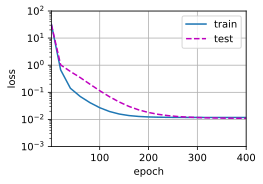

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.2463865 4.9294467]]


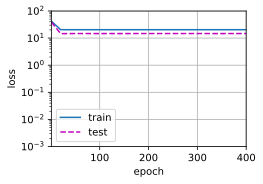

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.0014701e+00  1.2361516e+00 -3.3921983e+00  5.4177985e+00
  -8.9765690e-02  3.8124841e-01  3.2970324e-01 -1.4573458e-01
   3.2076889e-01  1.3193209e-02 -6.7385688e-02 -1.9144195e-01
  -2.5339529e-02 -1.4863391e-01  1.1941269e-01  7.4615046e-02
  -6.3415825e-02  1.7065336e-01  4.5117186e-04 -1.4724368e-01]]


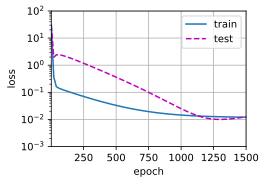

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)